# DA8 Epoching
06/26/2023

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import emd
import re
import scipy

import warnings
warnings.filterwarnings('ignore')

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
import sys
sys.path.append('/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/scripts/saez_python_pipeline/LFPAnalysis')

In [3]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils

In [4]:
# Specify root directory for un-archived data and results 
base_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/'
anat_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/anat_recons/recon_labels/'
neural_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/'
behav_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/behavior_analysis/behavior_preprocessed/'

subj_id = 'DA8'
subj_format = ['edf']
subj_site = ['UCD']


### Import Preprocessed Data

In [5]:
mne_data_reref = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/wm_ref_ieeg.fif', preload=True)

photodiode_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/photodiode.fif', preload=True)

In [6]:
mne_data_reref

<Raw | wm_ref_ieeg.fif, 57 x 1167360 (2280.0 s), ~507.7 MB, data loaded>

In [7]:
photodiode_data

<Raw | photodiode.fif, 1 x 1167360 (2280.0 s), ~8.9 MB, data loaded>

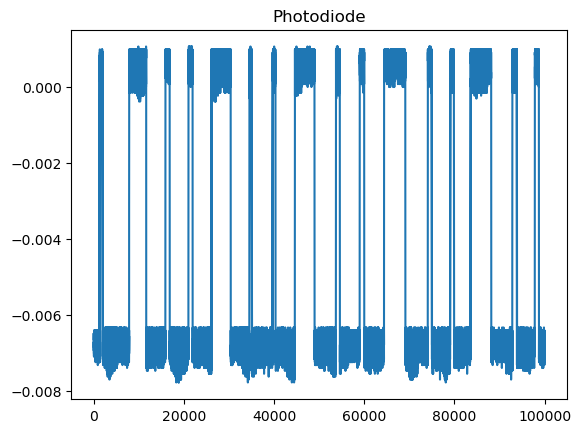

In [8]:
# Sanity check the photodiode
plt.plot(photodiode_data._data[0,400000:500000])
plt.title("Photodiode")
plt.show()

### Load Anat Recon Info 


In [8]:
# Load the electrode localization data
anat_file = glob(f'{anat_dir}{subj_id}_labels.csv')[0]
elec_locs = pd.read_csv(anat_file)
# Sometimes there's extra columns with no entries: 
elec_locs = elec_locs[elec_locs.columns.drop(list(elec_locs.filter(regex='Unnamed')))]

elec_locs

,label,BN246label,x,y,z,mni_x,mni_y,mni_z,gm,NMM,Anat,AnatMacro,BN246,YBA_1,ManualExamination
0,LAM1,rHipp_L,-21.200002,12.400003,-12.389971,-21.513494,-6.166145,-20.461219,Gray,Left Amygdala,Amygdala (LB),L Hippocampus,L Hipp,Left amygdala superior,NaN
1,LAM10,A21c_L,-64.800000,1.600004,-11.190942,-65.833070,-17.269594,-16.881921,Gray,Left MTG middle temporal gyrus,Unknown,L Middle Temporal Gyrus,L MTG,Left superior middle temporal gyrus B,NaN
2,LAM2,rHipp_L,-26.000002,11.200003,-11.990295,-26.428291,-7.416915,-19.952842,Gray,Left Amygdala,Amygdala (LB),L Hippocampus,L Hipp,Left amygdala superior,NaN
3,LAM3,rHipp_L,-30.800002,10.400003,-11.590618,-31.316592,-8.269546,-19.507002,Gray,Left Amygdala,CA1 (Hippocampus),L Hippocampus,L Hipp,Left hippocampus pes,WM
4,LAM4,Unknown,-35.600002,9.200003,-11.590618,-36.120244,-9.633351,-19.392629,White,Left Cerebral White Matter,Unknown,Unknown,Unknown,Unknown,WM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,LTT 5.00,A20r_L,-43.600001,14.800003,-23.181237,-43.323315,-8.034976,-33.571651,White,Left ITG inferior temporal gyrus,Unknown,L Inferior Temporal Gyrus,L ITG,Left basal inferior temporal gyrus A,WM
66,LTT 6.00,A20il_L,-47.600001,12.000003,-21.982207,-47.572561,-10.453217,-31.577884,White,Left ITG inferior temporal gyrus,Unknown,L Inferior Temporal Gyrus,L ITG,Left lateral inferior temporal gyrus A,WM
67,LTT 7.00,A20il_L,-51.200001,8.800003,-20.783178,-51.423078,-13.266819,-29.384452,White,Left ITG inferior temporal gyrus,Unknown,L Inferior Temporal Gyrus,L ITG,Left lateral inferior temporal gyrus A,NaN
68,LTT 8.00,A20il_L,-54.400000,4.800003,-19.184472,-54.886817,-16.673004,-26.370266,White,Left ITG inferior temporal gyrus,Unknown,L Inferior Temporal Gyrus,L ITG,Left lateral inferior temporal gyrus B,WM


## Load behavior

In [9]:
behav_df = pd.read_csv(f'{behav_dir}{subj_id}_pt_task_data')
behav_df = behav_df[behav_df.columns.drop(list(behav_df.filter(regex='Unnamed')))]
behav_df

,Round,Trial Num,TrialType,TrialOnset,ChoiceOnset,DecisionOnset,FeedbackOnset,RT,SafeBet,LowBet,...,weighted_low,p_g,p_s,util_rpe,util_tcpe,util_dcpe,util_tregret,util_dregret,util_trelief,util_drelief
0,1,42.0,mix,443.269265,443.271967,446.315833,446.323627,3.043866,0.0,-0.80,...,-1.949931,0.029823,0.970177,0.000000,1.949931,1.949931,0.000000,0.000000,1.949931,1.949931
1,2,35.0,mix,453.566390,453.578489,456.377342,458.393883,2.798853,0.0,-0.30,...,-0.593873,0.235281,0.764719,0.593873,0.000000,0.144929,0.000000,0.000000,0.738802,0.144929
2,3,34.0,mix,463.154404,463.155197,464.956437,464.964130,1.801240,0.0,-1.50,...,-4.177628,0.000147,0.999853,0.000000,-0.817361,-0.817361,-0.817361,-0.817361,0.000000,0.000000
3,4,57.0,gain,478.584467,478.594201,480.915804,482.932993,2.321603,0.2,0.00,...,0.000000,0.593053,0.406947,0.000000,0.000000,0.143437,0.000000,0.000000,0.285592,0.143437
4,5,105.0,loss,487.902771,487.912523,490.879291,490.887133,2.966768,-0.2,-0.50,...,-1.103065,0.271209,0.728791,0.000000,0.376491,0.376491,0.000000,0.000000,0.376491,0.376491
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,146,6.0,mix,2158.635428,2158.644915,2161.137752,2161.145673,2.492838,0.0,-0.30,...,-0.593873,0.211707,0.788293,0.000000,0.593873,0.593873,0.000000,0.000000,0.593873,0.593873
146,147,132.0,loss,2168.364954,2168.374467,2171.101107,2171.108969,2.726640,-0.5,-0.91,...,-2.279497,0.451991,0.548009,0.000000,-2.206130,-2.206130,-2.206130,-2.206130,0.000000,0.000000
147,148,64.0,gain,2184.344974,2184.354394,2186.209742,2188.226725,1.855348,0.3,0.00,...,0.000000,0.549287,0.450713,0.000000,0.000000,0.075332,0.000000,0.000000,0.307717,0.075332
148,149,111.0,loss,2192.838672,2192.849281,2194.506869,2194.514788,1.657587,-0.3,-0.50,...,-1.103065,0.555356,0.444644,0.000000,-0.084681,-0.084681,0.000000,0.000000,-0.084681,-0.084681


In [10]:
beh_ts = behav_df['TrialOnset']

## Troubleshooting photodiode alignment

In [12]:
np.min(photodiode_data._data)

-0.010604855604469776

In [13]:
np.max(photodiode_data._data)

0.0010681148851290345

In [11]:
test_photo = photodiode_data

In [12]:
test_photo._data = np.abs(photodiode_data._data[0, :]-np.nanmax(photodiode_data._data[0, :])) #consider resaving photodiode 

In [13]:
# Synchronize to the photodiode or whatever your neural sync signal is
slope, offset = sync_utils.synchronize_data(beh_ts, 
                                            test_photo, 
                                            smoothSize=11, windSize=15, height=0.005)

12 blocks
............

found matches for 120 of 184 pulses
9 blocks
.........

found matches for 100 of 184 pulses
7 blocks
.......

found matches for 125 of 184 pulses
6 blocks
......

found matches for 90 of 184 pulses
5 blocks
.....

found matches for 105 of 184 pulses


## Make epochs

In [14]:
# IED removal requires that we set some parameters for IED detection. 
# 1. peak_thresh: how many stds should they exceed the baseline by? 
# 2. closeness_thresh: how close should they be allowed to be (in sec) to other candidate IEDs? 
# 3. width_thresh: how wide should they have to be (in sec)?

# Defaults:
IED_args = {'peak_thresh':4,
           'closeness_thresh':0.25, 
           'width_thresh':0.2}


In [15]:

# Create a dictionary with your event name (matching your dataframe), and the time-window for the event
evs = {'TrialOnset': [-1.0, 0],
       'DecisionOnset': [0, 3.0]}

In [16]:
epochs_all_evs = {f'{x}': np.nan for x in evs}
epochs_all_baseline = {f'{x}': np.nan for x in evs}

In [18]:
for event in evs.keys():
    # Make the epochs. 
    ev_epochs = lfp_preprocess_utils.make_epochs(load_path=f'{neural_dir}{subj_id}/wm_ref_ieeg.fif', 
                 elec_path=anat_file, 
                 slope=slope, offset=offset,
                 behav_name=event, behav_times=behav_df[event].values, 
                 ev_start_s=evs[event][0], ev_end_s=evs[event][1], buf_s = 1.0, 
                 downsamp_factor=1, IED_args=IED_args)

    epochs_all_evs[event] = ev_epochs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 583 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 8432 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 8550 out of 8550 | elapsed:    2.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  57 out of  57 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 2040 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 8480 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 8550 out of 8550 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks     

In [19]:
epochs_all_evs

{'TrialOnset': <Epochs |  150 events (all good), -2 - 1 sec, baseline off, ~100.3 MB, data loaded, with metadata,
  'TrialOnset': 150>,
 'DecisionOnset': <Epochs |  150 events (all good), -1 - 4 sec, baseline off, ~167.1 MB, data loaded, with metadata,
  'DecisionOnset': 150>}

Should quality check IED removal in epoched data here ...

### Add metadata to epochs

In [20]:
for event in evs.keys():

    # Let's add our behavioral events to the metadata. Substitute this with the particulars for your behavioral dataframe. 

    event_metadata = epochs_all_evs[event].metadata.copy()
    
    #independent vars
    event_metadata['safe'] = behav_df['SafeBet'].tolist()
    event_metadata['low'] = behav_df['LowBet'].tolist()
    event_metadata['high'] = behav_df['HighBet'].tolist()
    event_metadata['profit'] = behav_df['Profit'].tolist()
    event_metadata['outcome'] = behav_df['Outcome'].tolist()
    #model-free vars
    event_metadata['g_ev'] = behav_df['GambleEV'].tolist()
    event_metadata['cr'] = behav_df['CR'].tolist()
    event_metadata['c_ev'] = behav_df['choiceEV'].tolist()
    event_metadata['rpe'] = behav_df['RPE'].tolist()
    event_metadata['tcpe'] = behav_df['totalCPE'].tolist()
    event_metadata['dcpe'] = behav_df['decisionCPE'].tolist()
    event_metadata['tregret'] = behav_df['totalRegret'].tolist()
    event_metadata['dregret'] = behav_df['decisionRegret'].tolist()
    event_metadata['trelief'] = behav_df['totalRelief'].tolist()
    event_metadata['drelief'] = behav_df['decisionRelief'].tolist()
    event_metadata['util_g'] = behav_df['util_g'].tolist()
    event_metadata['util_s'] = behav_df['util_s'].tolist()

    epochs_all_evs[event].metadata = event_metadata 
    

In [21]:
epochs_all_evs[event].metadata

,lam4,lam6,lhh7,ltp5,lip1,lip9,lip10,lpo1,lpo7,lpo8,...,c_ev,rpe,tcpe,dcpe,tregret,dregret,trelief,drelief,util_g,util_s
0,NaN,NaN,NaN,NaN,NaN,NaN,[1491],NaN,NaN,NaN,...,0.000,0.000,-1.20,-1.20,0.00,0.0,0.80,0.80,-1.326272,0.000000
1,NaN,NaN,NaN,NaN,NaN,NaN,[594],NaN,[699],[699],...,0.030,0.330,0.00,0.36,0.00,0.0,0.66,0.36,-0.448944,0.000000
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[626],[626],...,0.000,0.000,-1.50,-1.50,-1.50,-1.5,0.00,0.00,-3.360267,0.000000
3,NaN,NaN,NaN,NaN,NaN,NaN,[793],NaN,NaN,NaN,...,0.315,0.315,0.00,0.43,0.00,0.0,0.63,0.43,0.285592,0.142156
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000,0.000,-0.20,-0.20,0.00,0.0,0.30,0.30,-1.103065,-0.726574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,NaN,NaN,NaN,NaN,NaN,NaN,[1347],NaN,NaN,NaN,...,0.000,0.000,-0.25,-0.25,0.00,0.0,0.30,0.30,-0.500719,0.000000
146,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000,0.000,-0.50,-0.50,-0.50,-0.5,0.00,0.00,-2.279497,-2.206130
147,NaN,NaN,NaN,NaN,NaN,NaN,[1273],NaN,NaN,"[779, 1392]",...,0.335,0.335,0.00,0.37,0.00,0.0,0.67,0.37,0.307717,0.232385
148,NaN,NaN,NaN,NaN,NaN,NaN,[1280],NaN,NaN,NaN,...,0.000,0.000,-0.30,-0.30,0.00,0.0,0.20,0.20,-1.103065,-1.187746


### Save epoched data

In [22]:
for event in evs.keys():
    epochs_all_evs[event].save(f'{neural_dir}{subj_id}/epoch_{event}.fif', overwrite=True)